In [1]:
import numpy as np
import cv2 as cv
import matplotlib.path as mpltPath
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from haversine import inverse_haversine, Unit
import pickle

%matplotlib notebook


In [2]:
# cameraH maps from rectified to unrectified pixel coordinates
cameraH = np.array([[ 1.03570118e+00,  2.20209220e-01, -6.56401026e+01],
 [-2.47759214e-01,  9.72997542e-01,  7.11706249e+01],
 [ 1.01353307e-04, -5.38746250e-05,  1.00000000e+00]])

translation_vector = np.array([ -61.09920255, -16.,   0.])

R_left_abs = np.array([[ 0.9904186, -0.04264348, -0.13134906], 
 [ 0.13727167, 0.40789312 , 0.90265155],
 [ 0.01508419, -0.9120333, 0.40983865]])


### Create masks

In [3]:
#note: different resolutions have different coordinate systems...

#timestamp location for 1280x960
mask_points_time1 = np.array([[587, 19.3],
                             [587, 32.7],
                             [690.3, 32.7],
                             [690.3, 19.3]])

#timestamp location for 640x480
mask_points_time3 = np.array([[266, 33],
                             [266, 19],
                             [373, 19],
                             [373, 33],
                             [272, 33]])

#mask for buildings for camera 1, 1280x960 --> need to divde coordinates by 2 to get the 640x480 coordinates
img1_mask = np.array([[  2.78 , 869.98],
                             [ 3.40, 863.84],
                             [ 5.93, 863.07],
                             [ 6.7, 855.32],
                             [ 7.77,854.01],
                             [ 16.60, 853.17],
                             [ 41.55, 815.55],
                             [ 54.83, 805.65],
                             [ 56.14, 822.31],
                             [ 58.44, 840.66],
                             [ 64.28, 881.04],
                             [ 67.65, 881.81],
                             [ 73.18, 875.2],
                             [ 75.1 , 889.17],
                             [ 79.55 , 890.94],
                             [ 81.01, 894.47],
                             [90.38, 895.24],
                             [ 91.76, 907.29],
                             [96.44, 907.52 ],
                             [102.28, 899.62],
                             [110.18, 881.34],
                             [111.8, 882.8 ],
                             [115.17, 906.45],
                             [167.92, 906.68],
                             [179.92, 907.29],
                             [181.43, 902.61],
                             [185.03, 904.38],
                             [185.11, 910.36],
                             [191.64, 910.44 ],
                             [206.61, 889.41],
                             [214.74, 889.94],
                             [231.8, 908.2],
                             [246.5, 906.2],
                             [317.7, 906.4],
                             [319 , 879.3],
                             [328.9, 879.3],
                             [331.5 , 875.2],
                             [339.2 , 873.9],
                             [342.0, 862.4],
                             [355.6, 882.3],
                             [354.1, 912.3],
                             [376.4, 911.9 ],
                             [379.2, 902],
                             [392.1, 903.7],
                             [392.1, 909.2],
                             [415.2, 910.3],
                             [415.9, 918.7],
                             [469.2, 917.4],
                             [470.5, 912.1],
                             [476.5, 911.6],
                             [482.8, 779],
                             [893.2, 779],
                             [910.0, 938.5],
                             [1022.9, 939.0],
                             [1025.2, 952.8],
                             [1055.4, 952.8],
                             [1052.9, 929.3],
                             [1054.8, 929.3],
                             [1059.3, 956.1],
                             [1093.7, 955.9],
                             [1112.1, 957.8],
                             [1119.1, 941.2],
                             [1119.8, 916.2],
                             [1123.8, 916.8],
                             [1143.7, 956.9],
                             [1156.7, 958.2],
                             [1093.3, 624.8],
                             [1130.8, 551.1],
                             [1125.0, 518.1],
                             [1128.2, 478.4],
                             [1154.5, 526],
                             [1161.8, 551.1],
                             [1202.9, 587.3],
                             [1225.0, 593.7],
                             [1276.8, 801.0]])

#use this for the low res image (640x480) (i think)
img1_mask_lowres = img1_mask/2

#mask for buildings for camera 3 
img3_mask = np.array([[  0.0001 , 431.9],
                             [ 7.78, 397.65],
                             [ 15.16, 399.28],
                             [ 6.05, 445.8],
                             [ 27.63,448.1],
                             [ 28.01, 452.52],
                             [ 33.39, 452.99],
                             [ 34.73, 450.11],
                             [ 69.93, 451.65],
                             [ 71.18, 458.27],
                             [ 75.78, 457.31],
                             [ 76.74, 453.53],
                             [ 83.93, 453.47],
                             [ 84.32 , 457.12],
                             [ 89.11 , 457.6],
                             [ 90.07, 452.71],
                             [97.94, 453.09],
                             [ 98.23, 457.02],
                             [101.49, 456.45 ],
                             [101.49, 451.17],
                             [112.23, 452.62],
                             [114.92, 466.04 ],
                             [124.32, 449.93],
                             [124.70, 459.91],
                             [153.76, 459.52],
                             [154.82, 450.02],
                             [155.39, 451.46],
                             [162.2, 462.97],
                             [174.58, 436.5 ],
                             [176.88, 424.79],
                             [186.18, 424.41],
                             [190.21, 452.52],
                             [192.42, 434.29],
                             [196.25, 434.67],
                             [197.12 ,426.71],
                             [214.86, 427.29],
                             [215.63 , 451.17],
                             [220.23 , 439.28],
                             [226.66, 439.37],
                             [230.88, 460.38],
                             [240.66, 460.19],
                             [243.16, 454.53 ],
                             [251.89, 454.15],
                             [256.87, 446.57],
                             [263.97, 454.43],
                             [264.64, 462.68],
                             [268.1, 462.97],
                             [269.44, 456.45],
                             [278.65, 462.78],
                             [278.84, 459.33],
                             [281.24, 457.85],
                             [296.88, 457.6],
                             [296.1, 462.78],
                             [311.07, 463.55],
                             [313.27, 459.9],
                             [341.67, 460.57],
                             [342.34, 447.82],
                             [346.56, 447.91],
                             [346.37, 462.3],
                             [369.0, 460.76],
                             [368.81, 455.1],
                             [375.62, 455.01],
                             [375.81, 462.30],
                             [395.09, 462.11],
                             [395.0, 449],
                             [399.6, 449.35],
                             [399.5, 460.8],
                             [413.03, 462.3],
                             [412.16, 445.61],
                             [416.0, 444.07],
                             [415.04, 426.91],
                             [425.21, 426.04],
                             [427.13, 432.95],
                             [425.21, 426.04],
                             [427.13, 432.37],
                             [430.96, 426.04],
                             [433.46, 432.37],
                             [439.12,431.99],
                             [438.45, 399.95],
                             [443.05, 400.72],
                             [444.58, 430.93],
                             [555.56, 434.1],
                             [556.62, 437.94],
                             [567.74, 437.07],
                             [580.02, 430.26],
                             [599.88,429.40],
                             [604.19, 437.17],
                             [612.44, 437.46],
                             [613.3, 430.74],
                             [612.46, 432.76],
                             [622.03, 438.42],
                             [628.84, 438.61],
                             [636.04, 470.84],
                             [639.3, 470.55]])


def gen_mask(points, imshape, timemask=None):
    # make blank mask
    ind_y, ind_x = np.meshgrid(np.arange(0.5, imshape[1]),
                               np.arange(0.5, imshape[0]))
    # Ensure the points go to the edge of the image
    newpoints = [[641, points[-1, 1]],
                 [641, -1],
                 [-1, -1],
                 [-1, points[0, 1]],
                 [points[0, 0], points[0, 1]]]
    points = np.concatenate((points, newpoints), axis=0)
    points_poly = mpltPath.Path(points)
    mask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)

    if timemask is not None:
        points_poly = mpltPath.Path(timemask)
        tmask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)
        mask = mask & ~tmask
        
    return mask.transpose()[:, :, None].astype('uint8')

mask_C1 = gen_mask(img1_mask_lowres, (640, 480), timemask=mask_points_time1/2)
mask_C3 = gen_mask(img3_mask, (640, 480), timemask=mask_points_time3)

### Load extrinsic parameters for cameras

In [4]:
%cd "C:\Users\kathe\OneDrive\Documents\GitHub\cloud-stereo-new"
stereo_cal = pickle.load( open( 'stereo_cal_mat.pkl', "rb" ) )

C:\Users\kathe\OneDrive\Documents\GitHub\cloud-stereo-new


### Load camera images from video

In [5]:
%cd "C:\Users\kathe\OneDrive - Imperial College London\MSci Project\"

prefix_right = 'tl'
prefix_left = 'tl4'
vidfolder = "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/Videos/"
dtime = '2021-10-24'
hour = 12
frame_no = 1
vidcapR = cv.VideoCapture(f'{vidfolder}/{prefix_right}_{dtime}_{hour:0>2}A.mp4')
vidcapL = cv.VideoCapture(f'{vidfolder}/{prefix_left}_{dtime}_{hour:0>2}A.mp4')

# Check if camera opened successfully
if vidcapR.isOpened()== False:
    print("Error opening right camera")
if vidcapL.isOpened()== False:
    print("Error opening left camera")

vidcapR.set(cv.CAP_PROP_POS_FRAMES,frame_no) # Where frame_no is the frame you want
vidcapL.set(cv.CAP_PROP_POS_FRAMES,frame_no)
successR, imgRLarge = vidcapR.read() # Read the frame
#success, imgR = vidcapR.read()
successL, imgL = vidcapL.read()
if successR==True and successL == True:
    imgL = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)
    imgR = cv.resize(imgRLarge,(640,480),fx=0,fy=0, interpolation = cv.INTER_CUBIC)
    imgR = cv.cvtColor(imgR, cv.COLOR_BGR2RGB)
    vidcapR.release()
    vidcapL.release()

C:\Users\kathe\OneDrive - Imperial College London\MSci Project


### Undistort and rectify the images so that corresponding points are on epipolar lines

In [6]:
#camera matrices and distortion for the 640x480 resolution
#i am using the 640x480v2 values for both cameras because camera3 doesn't have its own
CamM_left = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])

CamM_right = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])

# camera matrices with the intrinsics that Ronnie was using
# CamM_left = np.array([[5.084752337001038995e+02,0.000000000000000000e+00, 3.225185456035997049e+02],
#                              [0.000000000000000000e+00,5.111127135158413921e+02,2.505901000840876520e+02],
#                              [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])
# CamM_right = np.array([[5.084752337001038995e+02,0.000000000000000000e+00, 3.225185456035997049e+02],
#                              [0.000000000000000000e+00,5.111127135158413921e+02,2.505901000840876520e+02],
#                              [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])

Distort_left = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])
Distort_right = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])
# Distort_left = np.array([2.557079871649052816e-01,-6.904984023652400715e-01,1.200890653459153572e-03,1.726519391474843354e-03,6.352641343146406827e-01])
# Distort_right = np.array([2.557079871649052816e-01,-6.904984023652400715e-01,1.200890653459153572e-03,1.726519391474843354e-03,6.352641343146406827e-01])

w, h = 640, 480

#assume both images have same height and width

new_camera_matrixleft, roi = cv.getOptimalNewCameraMatrix(CamM_left,Distort_left,(w,h),0,(w,h))
new_camera_matrixright, roi = cv.getOptimalNewCameraMatrix(CamM_right,Distort_right,(w,h),0,(w,h))

#Undistort images
imgR_undistorted = cv.undistort(imgR, CamM_right, Distort_right, new_camera_matrixright)
imgL_undistorted = cv.undistort(imgL, CamM_left, Distort_left, new_camera_matrixleft)

#creates new map for each camera with the rotation and pose (R and P) values
mapLx, mapLy = cv.initUndistortRectifyMap(new_camera_matrixleft, Distort_left, stereo_cal.get('Rleft'), stereo_cal.get('Pleft'), (w,h), cv.CV_32FC1)
mapRx, mapRy = cv.initUndistortRectifyMap(new_camera_matrixright, Distort_right, stereo_cal.get('Rright'), stereo_cal.get('Pright'), (w,h), cv.CV_32FC1)

# remaps each image to the new map
rimgR = cv.remap(imgR_undistorted, mapRx, mapRy,
                      interpolation=cv.INTER_NEAREST,
                      borderMode=cv.BORDER_CONSTANT,
                      borderValue=(0, 0, 0, 0))
rimgL = cv.remap(imgL_undistorted, mapLx, mapLy,
                      interpolation=cv.INTER_NEAREST,
                      borderMode=cv.BORDER_CONSTANT,
                      borderValue=(0, 0, 0, 0))

### Create stereo matching object and calculate disparity

In [7]:
# Create stereo matching object and set disparity parameters
# Note: disparity range is tuned according to specific parameters obtained through trial and error.
win_size = 3
min_disp = 0
max_disp = 4
num_disp = 16*max_disp - 16*min_disp # Needs to be divisible by 16
#Create Block matching object.
stereo = cv.StereoSGBM_create(minDisparity=min_disp,
 numDisparities = num_disp,
 blockSize = 3,
 uniquenessRatio = 7,
 speckleWindowSize = 75,
 speckleRange = 1,
 disp12MaxDiff = 6,
 P1 = 8*3*win_size**2,
 P2 =32*3*win_size**2)

# 0 64 3 91 509 60 55 0 55 4
# win_size = 3
# min_disp = 0
# num_disp = 64
# #Create Block matching object.
# stereo = cv.StereoSGBM_create(minDisparity=min_disp,
#  numDisparities = num_disp,
#  blockSize = 9,                             
#  uniquenessRatio = 0,
#  speckleWindowSize = 55,
#  speckleRange = 4,
#  disp12MaxDiff = 60,
#  P1 = 348,
#  P2 =509)

# # #Create Block matching object.
# stereo = cv.StereoSGBM_create(minDisparity=0,
#                              numDisparities = 64,
#                              blockSize = 15)

# maximumDisparities = 64

### DON'T MASK IMAGES BEFORE COMPUTING DISPARITY, IT MESSES UP THE DISPARITIES ###
# compute disparity map for the rectified images
disparity_map = stereo.compute(rimgL, rimgR).astype(np.float32)
# cv.filterSpeckles(disparity_map, 0, 512, maximumDisparities)
disparity_map[disparity_map < 0] = 0
disparity_map[disparity_map > 900] = 0
# convert to 3D depths (in camera 3 coordinate space)
im3d = cv.reprojectImageTo3D(disparity_map/16, stereo_cal.get('Q'), handleMissingValues = True)
im3d[im3d == np.inf] = None
im3d[im3d == -np.inf] = None
im3d[im3d > 9000] = None
im3d[im3d==0] = None

depths = np.sqrt(im3d[:,:,0]**2 + im3d[:,:,1]**2 + im3d[:,:,2]**2)
stereo_x = im3d[:,:,0]
stereo_y = im3d[:,:,1]
stereo_z = im3d[:,:,2]
ranges = np.sqrt(stereo_x**2 + stereo_y**2)

### Apply building and sky masks
Remember the masks need rectifying so that they match the images.

In [8]:
mask_C1_undistorted = cv.undistort(mask_C1[:,:,0].astype(np.uint8), CamM_right, Distort_right, new_camera_matrixright)
mask_C3_undistorted = cv.undistort(mask_C3[:,:,0].astype(np.uint8), CamM_left, Distort_left, new_camera_matrixleft)

rect_mask_C3 = cv.remap(mask_C3_undistorted, mapLx, mapLy,
                            interpolation=cv.INTER_NEAREST,
                            borderMode=cv.BORDER_CONSTANT,
                            borderValue=(0, 0, 0, 0))

rect_mask_C1 = cv.remap(mask_C1_undistorted, mapRx, mapRy,
                            interpolation=cv.INTER_NEAREST,
                            borderMode=cv.BORDER_CONSTANT,
                            borderValue=(0, 0, 0, 0))

rimgL_masked = cv.bitwise_and(rimgL, rimgL, mask=rect_mask_C3)
rimgR_masked = cv.bitwise_and(rimgR, rimgR, mask=rect_mask_C1)

### uncomment if you want to mask out sky ###
rg_ratio1 = rimgR[:, :, 1]/rimgR[:, :, 0]
skymask_C1 =  rect_mask_C1 & (rg_ratio1<1.1) & (rg_ratio1>0.93)

rg_ratio3 = rimgL_masked[:, :, 1]/rimgL_masked[:, :, 0]
skymask_C3 = rect_mask_C3 & (rg_ratio3<1.1) & (rg_ratio3>0.93)

combined_mask = mask_C3_undistorted & mask_C1_undistorted

#combine mask1 and mask3 and rectify 
combined_mask = cv.remap(combined_mask, mapLx, mapLy,
                            interpolation=cv.INTER_NEAREST,
                            borderMode=cv.BORDER_CONSTANT,
                            borderValue=(0, 0, 0, 0))
disp_mask = combined_mask & skymask_C3

rimgR_skymasked = cv.bitwise_and(rimgR, rimgR, mask=skymask_C1)
rimgL_skymasked = cv.bitwise_and(rimgL, rimgL, mask=skymask_C3)
depths = cv.bitwise_and(depths, depths, mask=disp_mask)
depths[depths==0] = None


<ipython-input-8-ce3f8a287e6d>:18: RuntimeWarning: invalid value encountered in true_divide
  rg_ratio1 = rimgR[:, :, 1]/rimgR[:, :, 0]
<ipython-input-8-ce3f8a287e6d>:21: RuntimeWarning: invalid value encountered in true_divide
  rg_ratio3 = rimgL_masked[:, :, 1]/rimgL_masked[:, :, 0]


### Plot rectifed images, disparity and depth maps

<IPython.core.display.Javascript object>


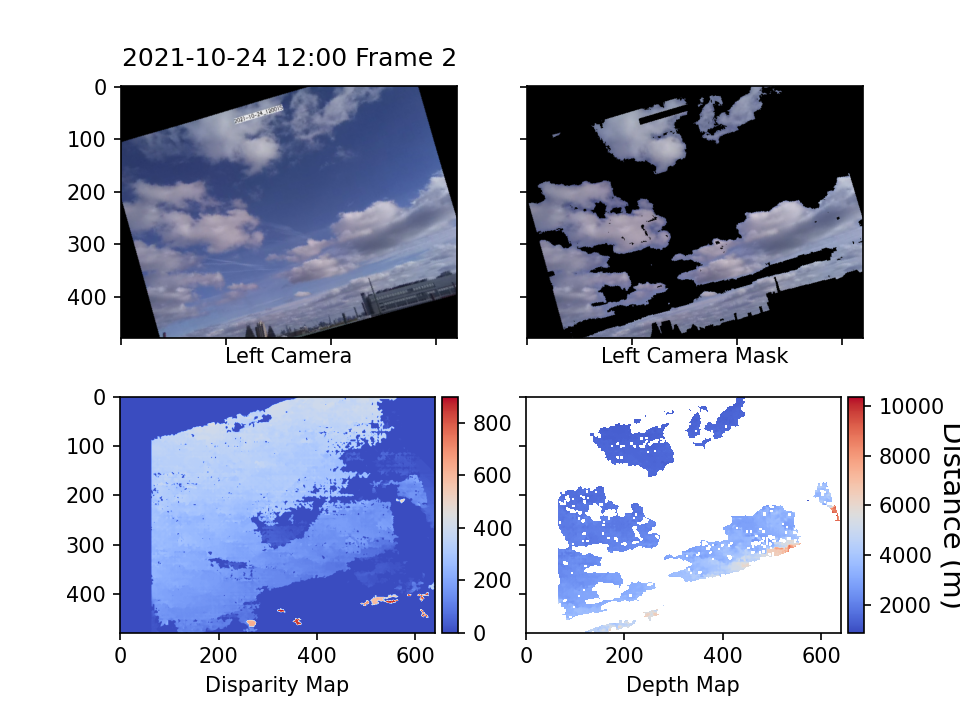

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True)
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['axes.labelsize'] = 14
ax1.set_xlabel('Left Camera')
ax1.set_title(f'{dtime} {hour}:00 Frame {frame_no+1}', pad=10)
ax2.set_xlabel('Left Camera Mask')
ax1.imshow(rimgL)
ax2.imshow(rimgL_skymasked)

disp = ax3.imshow(disparity_map,'coolwarm')
ax3.set_xlabel('Disparity Map')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(disp, cax=cax, orientation='vertical')
#cbar.set_label('Disparity', rotation=270, labelpad=6)

depth = ax4.imshow(depths, 'coolwarm')
ax4.set_xlabel('Depth Map')
divider2 = make_axes_locatable(ax4)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(depth, cax=cax2, orientation='vertical')
cbar2.set_label('Distance (m)', rotation=270, labelpad=10)
plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_DepthProcess.png', bbox_inches='tight', dpi=1000)
# print('frame number', frame_no+1)

### Plot altitude against distance from the camera
Minimum altitude should be roughly constant with distance, corresponding to consistent cloud base height for the whole cumulus layer

<ipython-input-23-84f1dd4c7746>:1: RuntimeWarning: divide by zero encountered in true_divide
  elev = np.arccos(stereo_z/depths)
<ipython-input-23-84f1dd4c7746>:1: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos(stereo_z/depths)


<IPython.core.display.Javascript object>


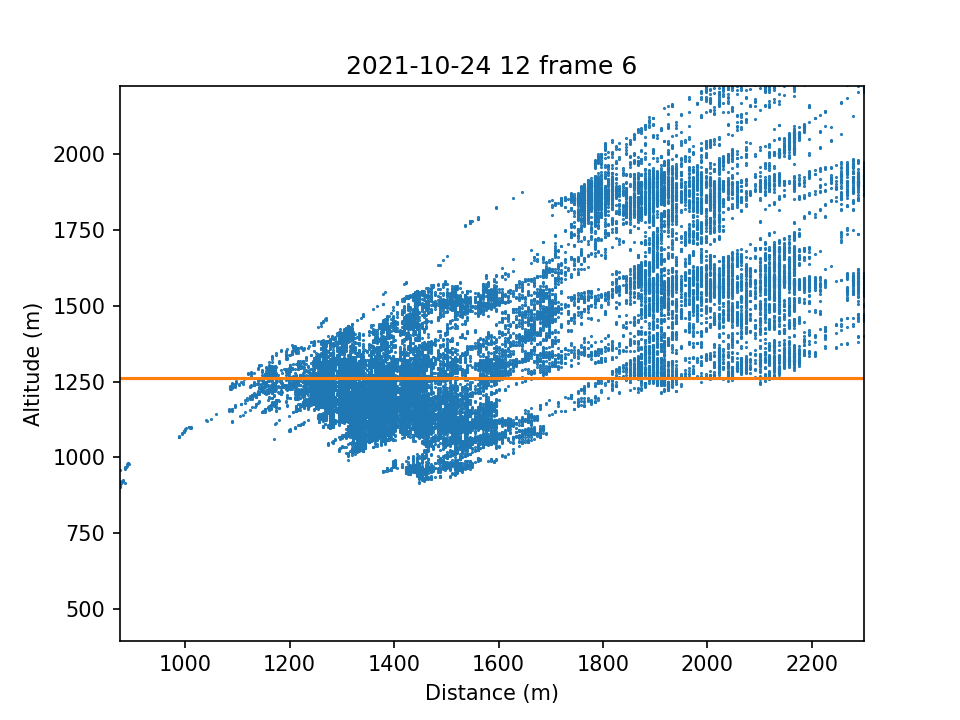

Text(0.5, 1.0, '2021-10-24 12 frame 6')

In [23]:
elev = np.arccos(stereo_z/depths)
tilt = (np.pi/180) * 23
height = stereo_z * np.tan(tilt + elev) + 46

fig,ax = plt.subplots(1,1)
ax.plot(stereo_z.flatten(), height.flatten(), '.', ms=1)
x = np.arange(0,8000,1)
y = np.ones(8000)
ax.plot(x, 1260*y)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Altitude (m)')
ax.set_title(f'{dtime} {hour} frame {frame_no+1}')
#plt.savefig('altitudeDistanceScatter.png', bbox_inches='tight')

### Test if there is something going on with reprojectImageTo3D by repeating manually what you think the code is doing (i.e. multiply by Q)
- As per the answer to this question: https://stackoverflow.com/questions/22418846/reprojectimageto3d-in-opencv except multiply by fourth element rather than dividing?
- Note we have also transformed back to the unrectified pixel coordinates using cameraH before projecting into 3D coords




(70104, 3)


<IPython.core.display.Javascript object>


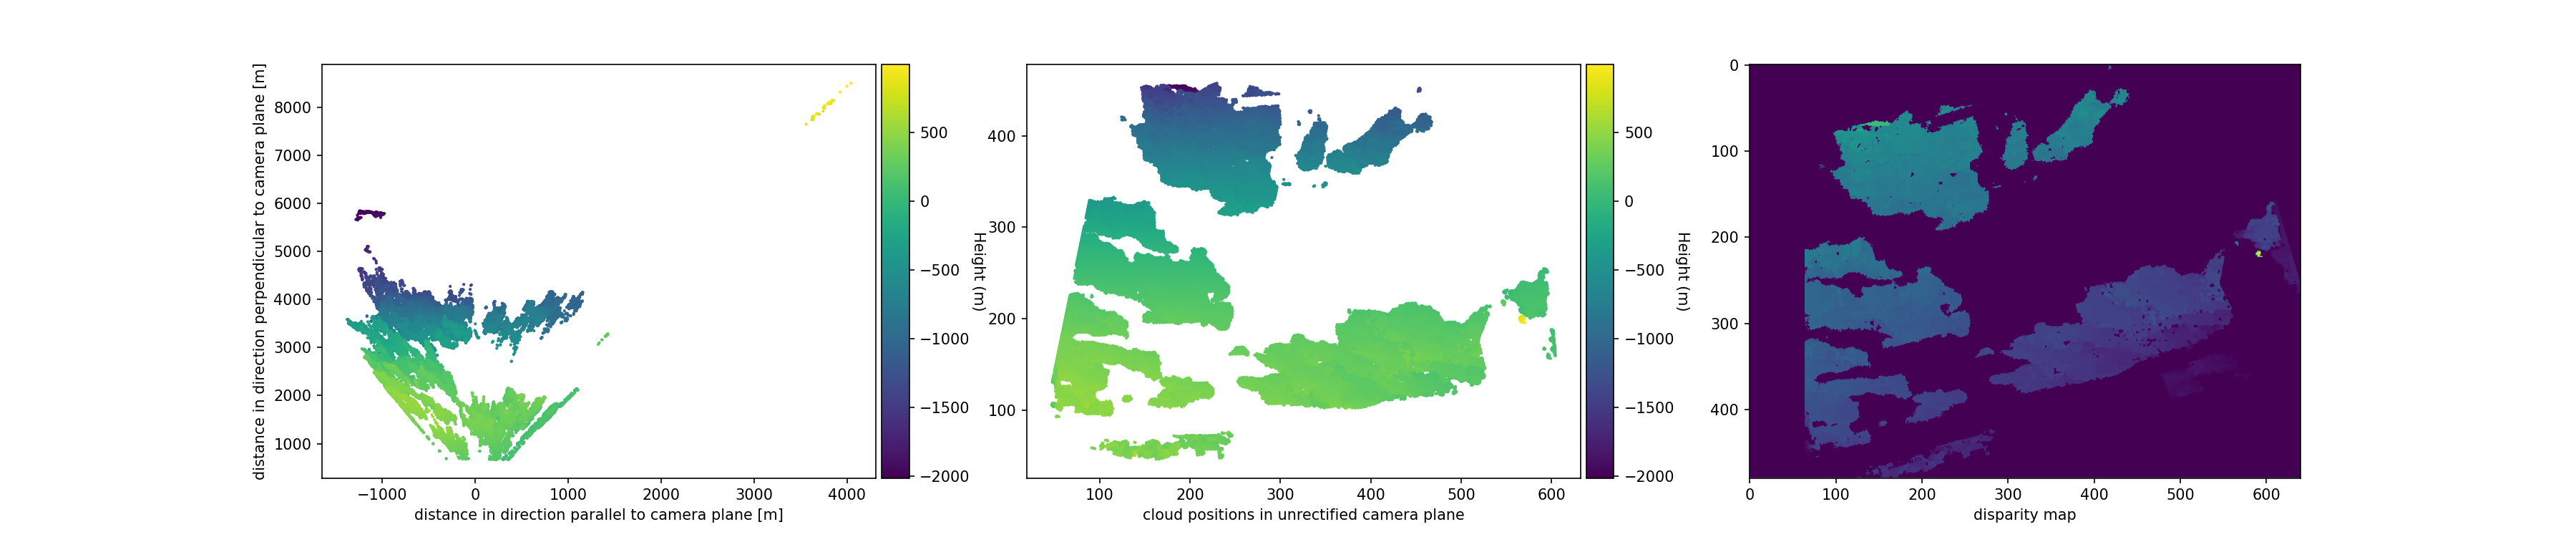

Text(0.5, 0, 'disparity map')

In [24]:
#optional cloud mask
disparity_map = cv.bitwise_and(disparity_map, disparity_map, mask=disp_mask)

# #optional building mask
# disparity_map = cv.bitwise_and(disparity_map, disparity_map, mask=rect_mask_C1)

unrect_pixels_dists = []
world_points = []

for i in range(0,480):
    for j in range(0,640):
        if disparity_map[i,j] > 64:
            rect_pixels = np.array([j,i,1])
            unrect_pixels = np.matmul(np.linalg.inv(cameraH), rect_pixels)
            im_point = np.array([unrect_pixels[0], unrect_pixels[1], disparity_map[i,j], 1])
            world_point = np.matmul(stereo_cal.get('Q'), im_point)
             
            world_point = world_point * world_point[3]
            #try transforming by Ronnie's matrix
            # test = np.array([world_point[0], world_point[1], world_point[2]])
            # world_point = np.matmul(#, test)
            world_points.append(world_point)
            unrect_pixels_dists.append(np.array([unrect_pixels[0], unrect_pixels[1], world_point[2]]))
            
world_points = np.array(world_points)
#world_points[world_points[:,2] < 1000] = None
unrect_pixels_dists = np.array(unrect_pixels_dists)
print(unrect_pixels_dists.shape)

# coordinate order for world_points:
# x = distance parallel to camera plane
# y = height
# z = horizontal distance from the camera, normal to camera plane

# Note world_points is in the UNRECTIFIED camera coordinates

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(24,5))
#world = ax.scatter((world_points[:,0]- max(world_points[:,0]))+640, max(world_points[:,1]) - world_points[:,1], 1, world_points[:,2])
world = ax1.scatter(world_points[:,0], world_points[:,2], 1 , world_points[:,1])
ax1.set_xlabel('distance in direction parallel to camera plane [m]')
ax1.set_ylabel('distance in direction perpendicular to camera plane [m]')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(world, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=10)


test = ax2.scatter(unrect_pixels_dists[:,0], 500-unrect_pixels_dists[:,1], 1, world_points[:,1])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(test, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=10)
ax2.set_xlabel('cloud positions in unrectified camera plane')

ax3.imshow(disparity_map)
ax3.set_xlabel('disparity map')

#plt.savefig('manualQNoGPS.png', bbox_inches='tight')

### Find x and y 3D coordinates by calculating azimuth and elevation from (unrectified) pixel coordinates and then using trig with the reprojected z coordinate
See 18/2/22 in paper lab book

<IPython.core.display.Javascript object>


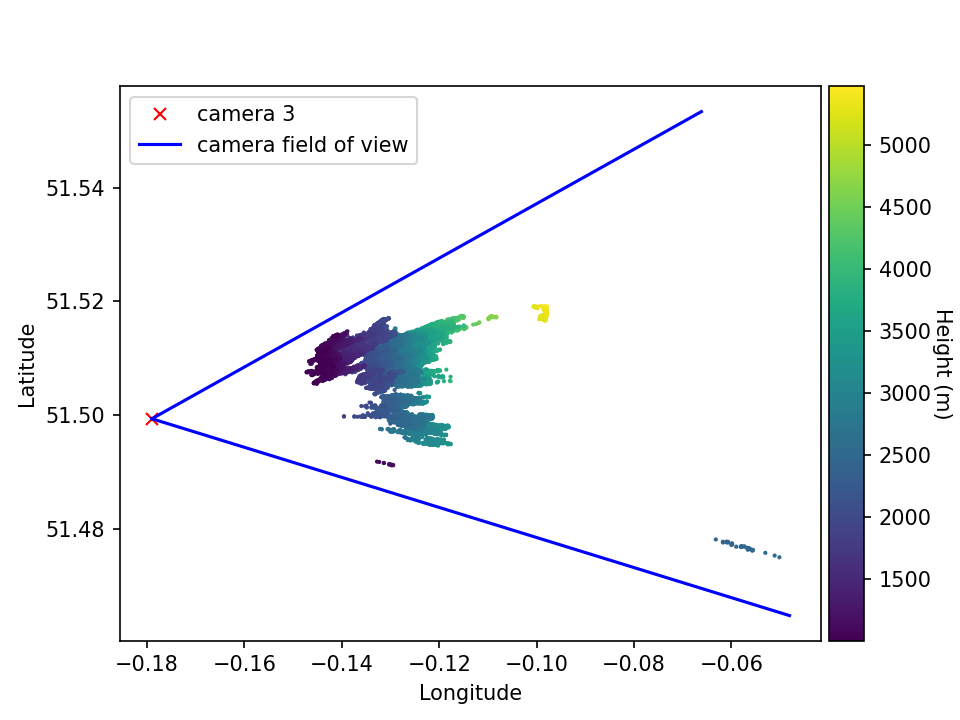

In [25]:
tilt = np.pi/180 * 23.702596 
heading = np.pi/180 * 82.665769

world_dists_manual = []
gps_dists_manual = []
for w in unrect_pixels_dists:
    elev = np.arctan( (2.362389385357402034e+02 - w[1]) / 5.502640890663026312e+02)
    azi = np.arctan( (w[0] - 3.225866125962970159e+02) / 5.520688775958645920e+02)
    perp_dist = w[2] * np.tan(azi)
    height = w[2] * np.tan(tilt + elev) + 46
    if height > 1000:
        world_dists_manual.append(np.array([perp_dist, w[2], height]))
        bearing = heading + azi
        dist = np.sqrt(perp_dist**2 + w[2]**2)
        gps = inverse_haversine((51.4993318750954, -0.17901837289811393), dist, bearing, unit=Unit.METERS)
        gps_dists_manual.append(np.array([gps[0], gps[1], height]))
    
world_dists_manual = np.array(world_dists_manual)
gps_dists_manual = np.array(gps_dists_manual)

# coordinate order for world_dists_manual:
# x = distance parallel to camera plane, measured from camera centre
# y = distance from camera perpendicular to camera plane (i.e. stereo_z or the distance calculated from the disparity map)
# z = height from the ground

# coordinate order for gps_dists_manual
# x = latitude
# y = longitude
# z = heights

# calculate maximum extent of camera view
max_elev = np.arctan(2.362389385357402034e+02 / 5.502640890663026312e+02)
max_azi = np.arctan(3.225866125962970159e+02 / 5.520688775958645920e+02)
camera_max_x = np.max(world_dists_manual[:,1]) * np.tan(max_azi)
camera_max_dist = np.sqrt(camera_max_x**2 + np.max(world_dists_manual[:,1])**2)
camera_max_gps = inverse_haversine((51.4993318750954, -0.17901837289811393), camera_max_dist, heading+max_azi, unit=Unit.METERS)
camera_min_gps = inverse_haversine((51.4993318750954, -0.17901837289811393), camera_max_dist, heading-max_azi, unit=Unit.METERS)

fig, ax = plt.subplots(1,1)
gps = ax.scatter(gps_dists_manual[:,1], gps_dists_manual[:,0], 1, gps_dists_manual[:,2])
ax.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3')
ax.plot([-0.17901837289811393, camera_max_gps[1]], [51.4993318750954, camera_max_gps[0]], 'b-', label='camera field of view')
ax.plot([-0.17901837289811393, camera_min_gps[1]], [51.4993318750954, camera_min_gps[0]], 'b-')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(gps, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=10)
ax.legend()

### check heights against METAR data

<IPython.core.display.Javascript object>


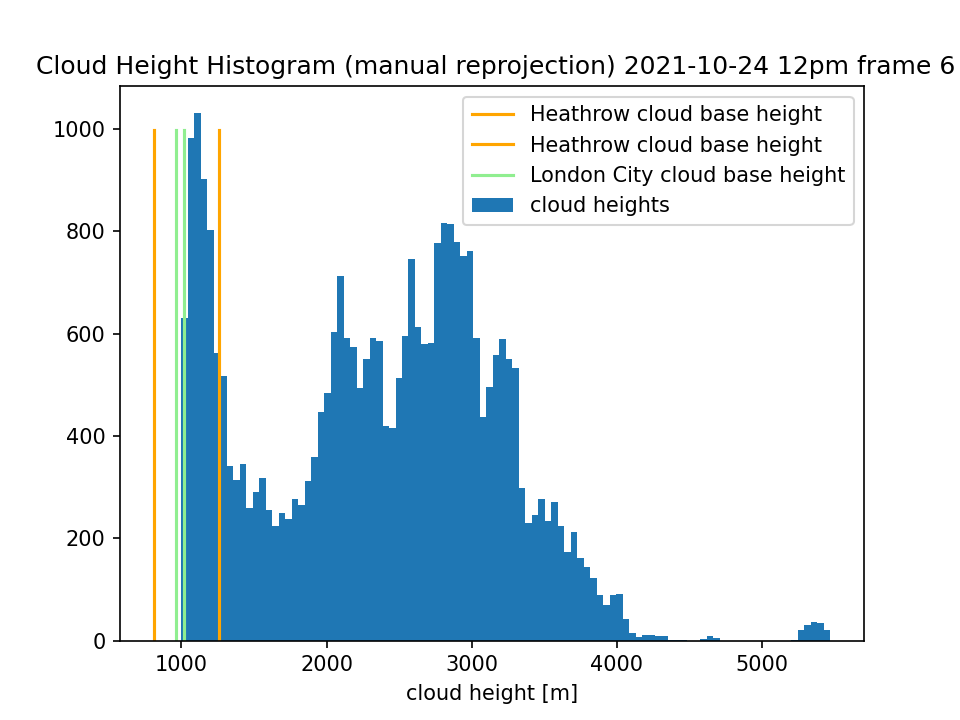

In [82]:
fig, ax = plt.subplots(1,1)
ax.hist(gps_dists_manual[:,2], bins=100, label='cloud heights')
y = np.arange(0,1000,1)
x = np.ones(1000)
ax.plot(1260*x, y, color='orange', label='Heathrow cloud base height')
ax.plot(960*x, y, color='lightgreen', label='London City cloud base height')
ax.plot(1020*x, y, color='lightgreen')
ax.set_xlabel('cloud height [m]')
ax.set_title(f' Cloud Height Histogram (manual reprojection) {dtime} {hour}pm frame {frame_no+1}')
ax.legend()
#plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_heights_histogram_manual.png', bbox_inches = 'tight')~

## Now repeat similar method using the 3d distances from camera found using reprojectImageTo3D
First convert back to unrectified coordinates (reprojectImageTo3D gives points in the rectified coordinate system of the left camera)

<IPython.core.display.Javascript object>


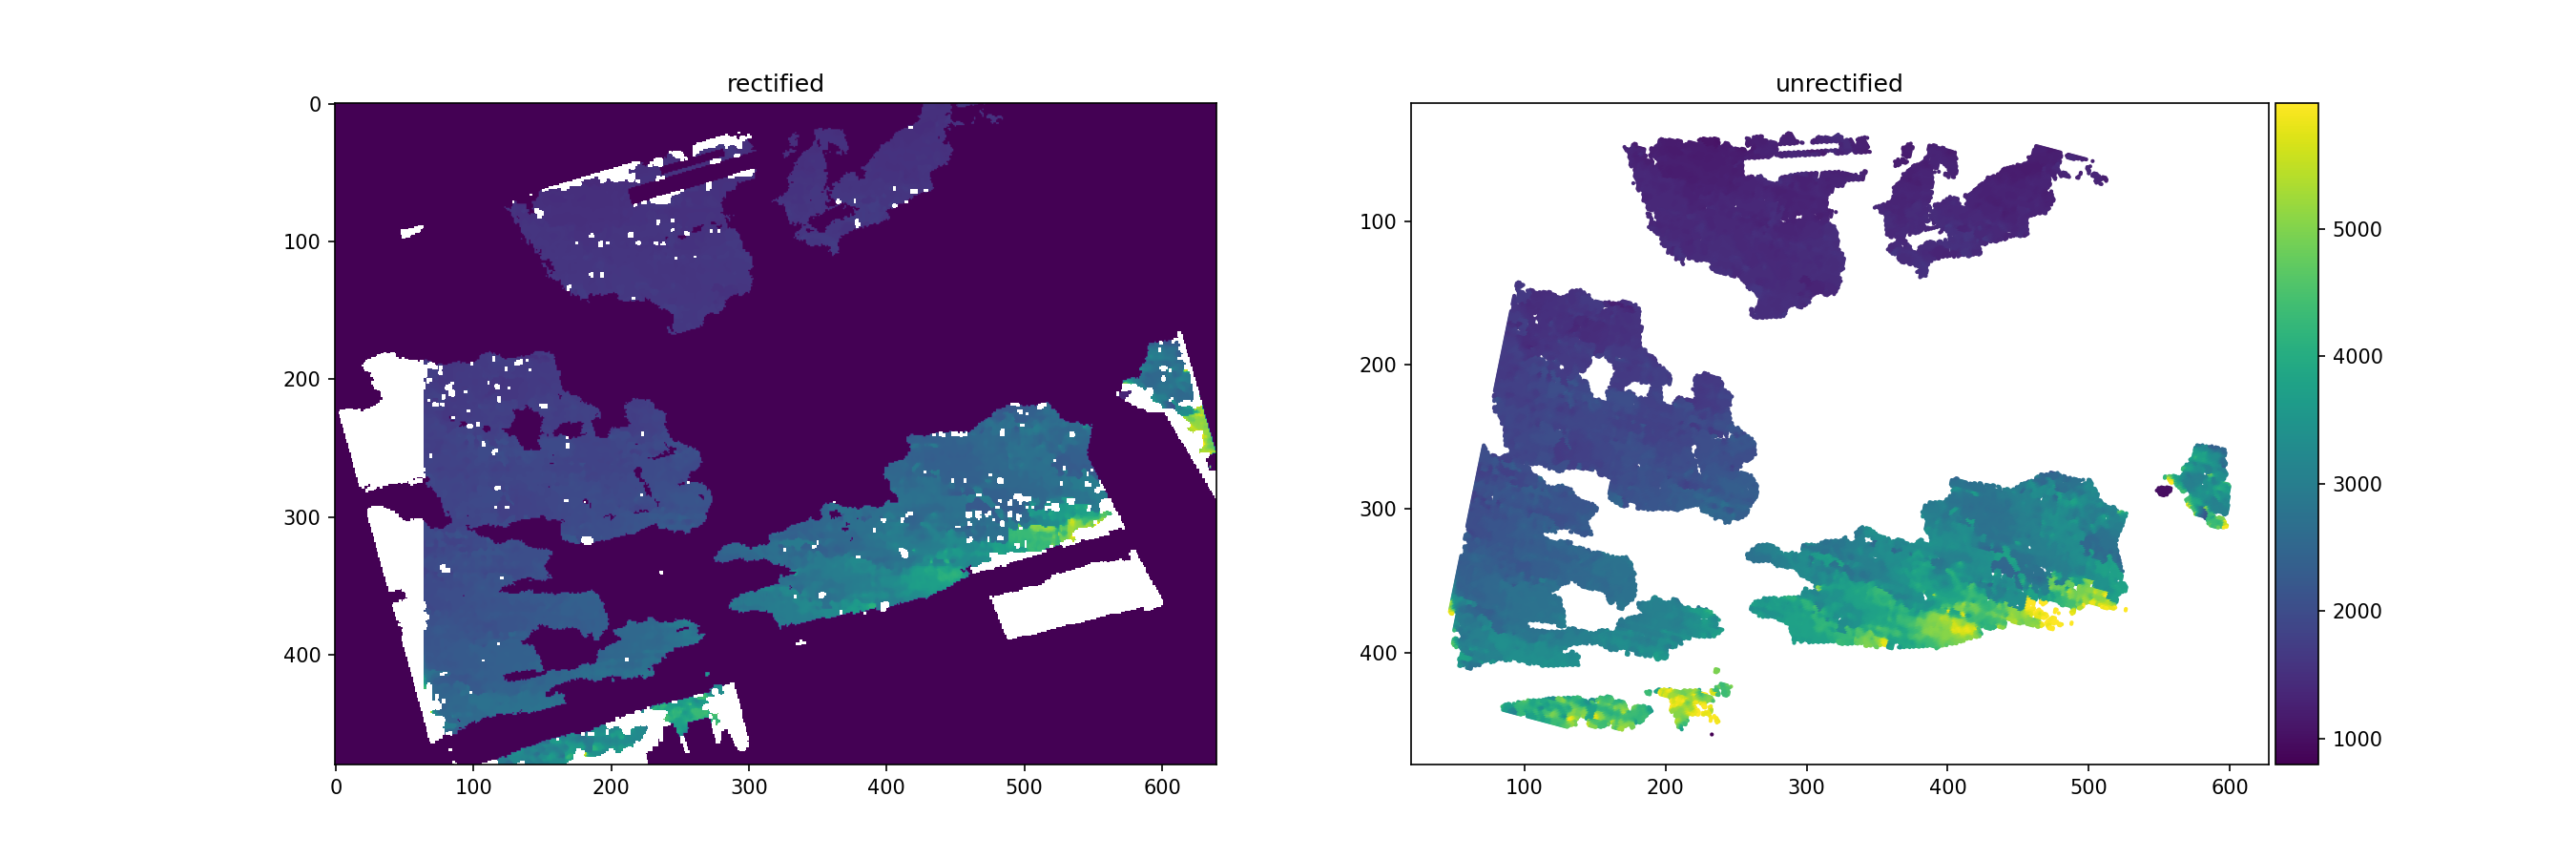

Text(0.5, 1.0, 'unrectified')

In [10]:
stereo_z_masked = cv.bitwise_and(stereo_z, stereo_z, mask=disp_mask)

unrect_z = []
for i in range(0,480):
    for j in range(0,640):
        if 0 < stereo_z_masked[i,j] < 6000:
            rect_point = np.array([j,i,1])
            unrect_point = np.matmul(np.linalg.inv(cameraH), rect_point)
            unrect_z.append(np.array([unrect_point[0], unrect_point[1], stereo_z_masked[i,j], depths[i,j]]))
unrect_z = np.array(unrect_z)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6))
ax1.imshow(stereo_z_masked)
ax1.set_title('rectified')
rec = ax2.scatter(unrect_z[:,0], unrect_z[:,1], 1, unrect_z[:,2])
plt.gca().invert_yaxis()
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(rec, cax=cax, orientation='vertical')
ax2.set_title('unrectified')

### Calculate world coordinates, again using the trig method with azimuth and elevation

<IPython.core.display.Javascript object>


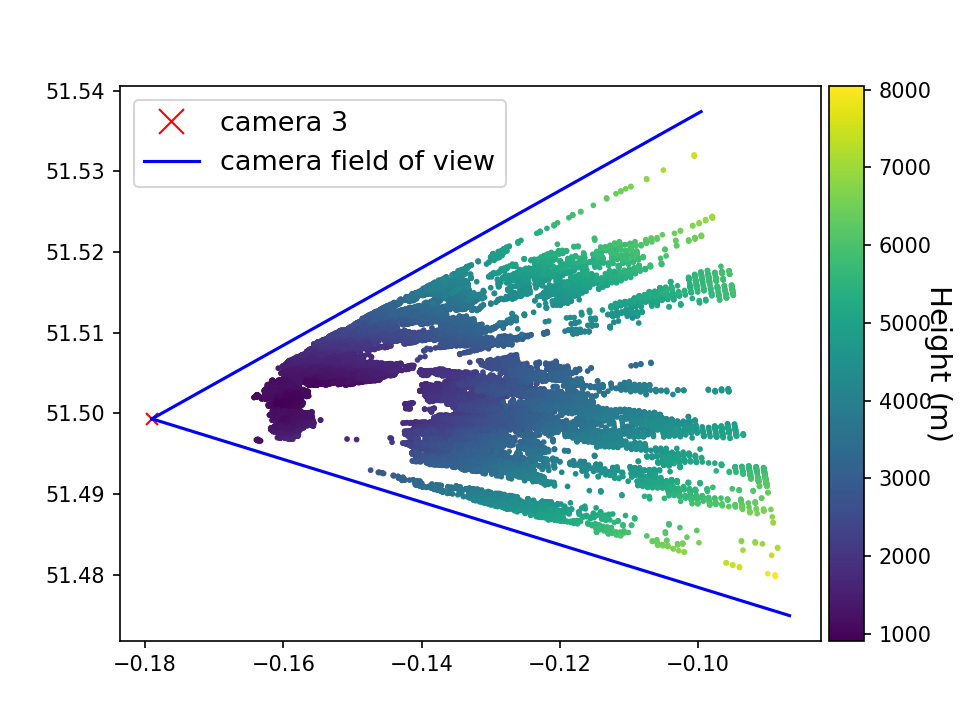

In [11]:
# absolute tilt (angle measured upwards from horizontal) and heading (bearing from north) of camera 3, calculated using cameratransform
tilt = (np.pi/180) * 23.702596 
heading = (np.pi/180) * 82.665769

world_dists_auto = []
gps_dists_auto = []
for z in unrect_z:
        if z[2] > 1000:
            elev = np.arctan( (2.362389385357402034e+02 - z[1]) / 5.502640890663026312e+02)
            elev2 = np.arccos(z[2]/z[3]) 
            azi = np.arctan( (z[0] - 3.225866125962970159e+02) / 5.520688775958645920e+02)
            perp_dist = z[2] * np.tan(azi)
            height = z[2] * np.tan(tilt + elev2) + 46
            if height > 500:
#                 world_rot = np.matmul(np.linalg.inv(R_left_abs), np.array([perp_dist, z[2], height]))
#                 world_dists_auto.append(world_rot)
                world_dists_auto.append(np.array([perp_dist, z[2], height]))
                bearing = heading + azi
                dist = np.sqrt(perp_dist**2 + z[2]**2)
#                 dist = np.sqrt(world_rot[0]**2 + world_rot[1]**2)
                gps = inverse_haversine((51.4993318750954, -0.17901837289811393), dist, bearing, unit=Unit.METERS)
                gps_dists_auto.append(np.array([gps[0], gps[1], height]))
    
world_dists_auto = np.array(world_dists_auto)
gps_dists_auto = np.array(gps_dists_auto)

# coordinate order for world_dists_auto:
# x = distance parallel to camera plane, measured from camera centre
# y = distance from camera perpendicular to camera plane (i.e. stereo_z or the distance calculated from the disparity map)
# z = height from the ground

# coordinate order for gps_dists_auto:
# x = latitude
# y = longitude
# z = height

# calculate maximum extent of camera view
max_elev = np.arctan(2.362389385357402034e+02 / 5.502640890663026312e+02)
max_azi = np.arctan(3.225866125962970159e+02 / 5.520688775958645920e+02)
camera_max_x = np.max(world_dists_auto[:,1]) * np.tan(max_azi)
camera_max_dist = np.sqrt(camera_max_x**2 + np.max(world_dists_auto[:,1])**2)
camera_max_gps = inverse_haversine((51.4993318750954, -0.17901837289811393), camera_max_dist, heading+max_azi, unit=Unit.METERS)
camera_min_gps = inverse_haversine((51.4993318750954, -0.17901837289811393), camera_max_dist, heading-max_azi, unit=Unit.METERS)

fig, ax = plt.subplots(1,1)
height = ax.scatter(gps_dists_auto[:,1], gps_dists_auto[:,0], 3, gps_dists_auto[:,2])
ax.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3')
ax.plot([-0.17901837289811393, camera_max_gps[1]], [51.4993318750954, camera_max_gps[0]], 'b-', label='camera field of view')
ax.plot([-0.17901837289811393, camera_min_gps[1]], [51.4993318750954, camera_min_gps[0]], 'b-')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(height, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=10)
ax.legend()

### Plot height against distance to see if you get a constant cloud base height

<IPython.core.display.Javascript object>


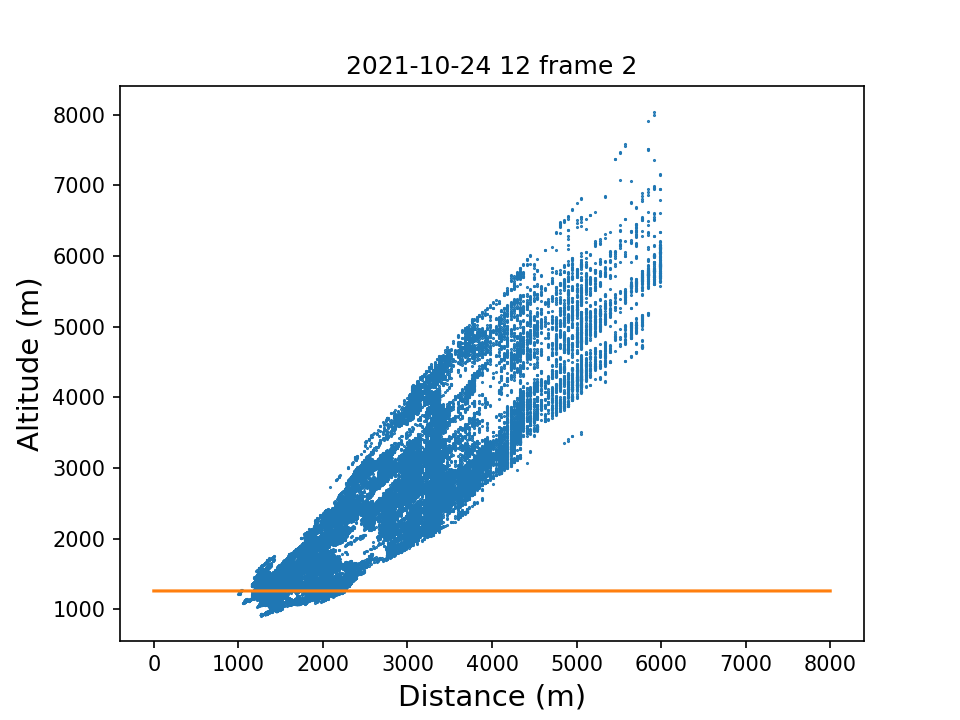

(480, 640)


In [12]:
elev2 = np.arccos(stereo_z/depths)
tilt = (np.pi/180) * 25.6#23.702596
height = stereo_z * np.tan(tilt + elev2) + 46

fig,ax = plt.subplots(1,1)
# ax.plot(world_dists_manual[:,1], world_dists_manual[:,2], '.', ms=1)
ax.plot(world_dists_auto[:,1], world_dists_auto[:,2], '.', ms=1)
#ax.plot(stereo_z.flatten(), height.flatten(), '.', ms=1)
x = np.arange(0,8000,1)
y = np.ones(8000)
ax.plot(x, 1260*y)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Altitude (m)')
ax.set_title(f'{dtime} {hour} frame {frame_no+1}')
#plt.savefig('altitudeDistanceScatter.png', bbox_inches='tight')

print(stereo_z.shape)

## 3D projection using cameratransform

In [65]:
import cameratransform as ct
# Our origin is at camera 3 so we want all the parameters for this camera

# intrinsic camera parameters
f_mm = 3.04    # in mm
#pixel_size = 1.12e-3 # length of one side of square pixel in mm
pixel_size = 5.75e-3
sensor_size = (3.68, 2.76) # in mm
image_size = (w,h)    # in px
f_x_px = (f_mm /sensor_size[0]) * image_size[0] #focal length relative to pixel width
f_y_px = (f_mm /sensor_size[1]) * image_size[1] #focallength relative to pixel height

camera = ct.Camera(ct.RectilinearProjection(focallength_x_px = f_x_px, focallength_y_px = f_y_px, image = rimgL))
camera.setGPSpos(51.4993318750954, -0.17901837289811393, 46)
#using values calculated for camera 3 using cameratransform
camera.elevation_m = 45.331277  
camera.tilt_deg = 113.702596 
camera.heading_deg = 82.665769
camera.roll_deg = -1.204690        #110.847355 90.425038 -19.934881

In [66]:
L = np.array([[0,-1,0],      # goes from coordinates that cameratransform is using to coordinates that im3d is using
              [0,0,1],
              [-1,0,0]])

L_inv = np.linalg.inv(L)

h = 82.665769
t = 113.702596 - 90
r =-1.204690

R = np.array([[np.cos(h)*np.cos(r) - np.sin(h)*np.sin(t)*np.sin(r), 
                                    -np.sin(h)*np.cos(t), 
                                    np.cos(h)*np.cos(r) + np.sin(h)*np.sin(t)*np.sin(r)],

                [np.sin(h)*np.cos(r)-np.cos(h)*np.sin(t)*np.sin(r), 
                                    np.cos(h)*np.cos(t), 
                                    np.sin(h)*np.sin(r)-np.cos(h)*np.sin(t)*np.cos(r)],

                [-np.cos(t)*np.sin(r), np.sin(t), np.cos(t)*np.cos(r)]])


roll_rot = np.array([[np.cos(r), 0, np.sin(r)],
                    [0,          1,         0],
                    [-np.sin(r), 0, np.cos(r)]])

heading_rot = np.array([[np.cos(h), -np.sin(h), 0],
                        [np.sin(h), np.cos(h),  0],
                        [0,         0,          1]])

tilt_rot = np.array([[1,        0,         0],
                    [0, np.cos(t), -np.sin(t)],
                    [0, np.sin(t), np.cos(t)]])


def cam2world(cam, l, r):
    l_inv = np.linalg.inv(l)
    r_inv = np.linalg.inv(r)
    flip = np.matmul(l_inv, cam)
    return np.matmul(r_inv, flip)


def cam2worldv2(cam, head=heading_rot, tilt=tilt_rot, roll=roll_rot, l=L):
    head_inv = np.linalg.inv(head)
    tilt_inv = np.linalg.inv(tilt)
    roll_inv = np.linalg.inv(roll)
    l_inv = np.linalg.inv(l)
    rot = np.matmul(head_inv, tilt_inv, roll_inv)
    flip = np.matmul(l_inv, cam)
    return np.matmul(rot, cam)


def world2gps(x, y, origin=(51.4993318750954, -0.17901837289811393)):
    dist = np.sqrt(x**2 + y**2)
    angle = np.arctan(y/x)
    return inverse_haversine(origin, dist, angle, unit=Unit.METERS)



In [14]:
depth_x = []
depth_y = []
depth_val = []
space_coords = []
world_coords = []
heights = []
for j in range (0,480):
    for i in range (0,640):
        if 0 < depths[j,i] < 50000:
            if stereo_z[j,i] != 0:
                depth_val.append(depths[j,i])
                depth_x.append(i)
                depth_y.append(j)
                elev = np.arccos(stereo_z[j,i]/depths[j,i])
                tilt = (np.pi/180) * (camera.tilt_deg - 90)
                #flip = np.matmul(L_inv, np.array([stereo_x[j,i], stereo_y[j,i], stereo_z[j,i]]))
                world_coord = camera.gpsFromSpace(np.array([stereo_z[j,i], -stereo_x[j,i], stereo_y[j,i]]))
                #world_coord = cam2worldv2(np.array([stereo_x[j,i], stereo_y[j,i], stereo_z[j,i]]))
                #gps = world2gps(world_coord[0], world_coord[1])
                height = stereo_z[j,i] * np.tan(tilt + elev) + 46
                heights.append(height)
                world_coords.append(world_coord)    
                space_coord = camera.spaceFromImage([i,j], Z=depths[j,i])
                space_coords.append(np.array(space_coord))
        
depth_x = np.array(depth_x)
depth_y = np.array(depth_y)  
depth_val = np.array(depth_val)
space_coords = np.array(space_coords)
world_coords = np.array(world_coords)
heights = np.array(heights)


print(world_coords.shape)

NameError: name 'camera' is not defined

In [15]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
world = ax.scatter(world_coords[:,1], world_coords[:,0], 1, heights)
ax.plot(-0.1788492157810761, 51.49880908055068, 'cx', label='camera 1 position')
ax.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3 position')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(world, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=20)
ax.legend()
#plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_world_Ronnie.png', bbox_inches='tight')


<IPython.core.display.Javascript object>

TypeError: list indices must be integers or slices, not tuple

<IPython.core.display.Javascript object>


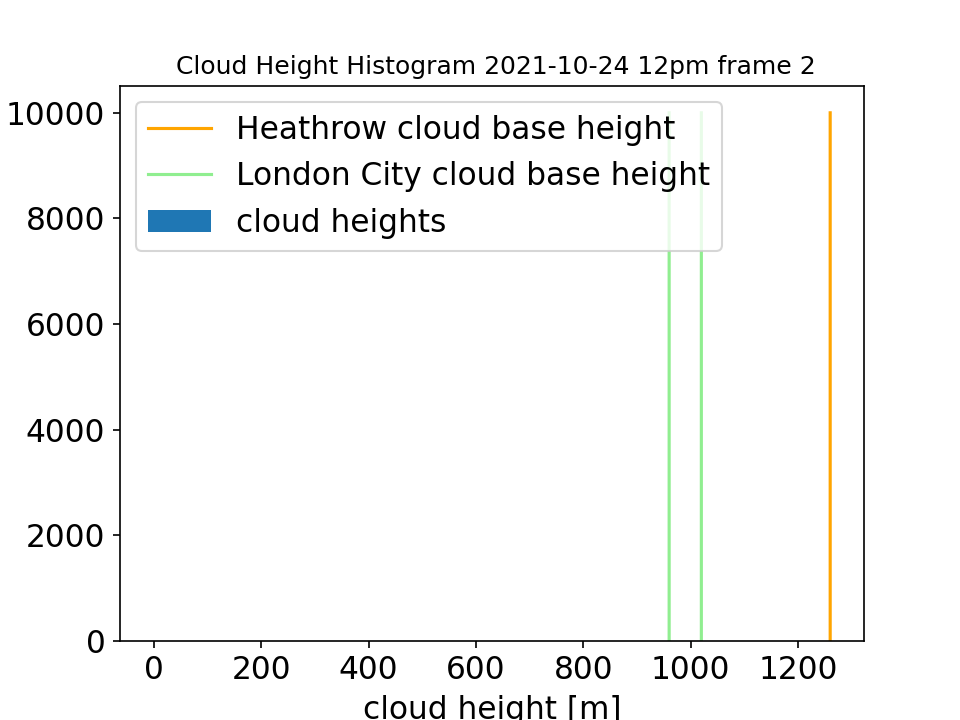

In [16]:
fig, ax = plt.subplots(1,1)
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['axes.labelsize'] = 15
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.hist(heights, bins=100, label='cloud heights')
y = np.arange(0,10000,1)
x = np.ones(10000)
ax.plot(1260*x, y, color='orange', label='Heathrow cloud base height')
ax.plot(960*x, y, color='lightgreen', label='London City cloud base height')
ax.plot(1020*x, y, color='lightgreen')
ax.set_xlabel('cloud height [m]')
ax.set_title(f' Cloud Height Histogram {dtime} {hour}pm frame {frame_no+1}')
ax.legend()
#plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_heights_histogram.png', bbox_inches = 'tight')


<IPython.core.display.Javascript object>


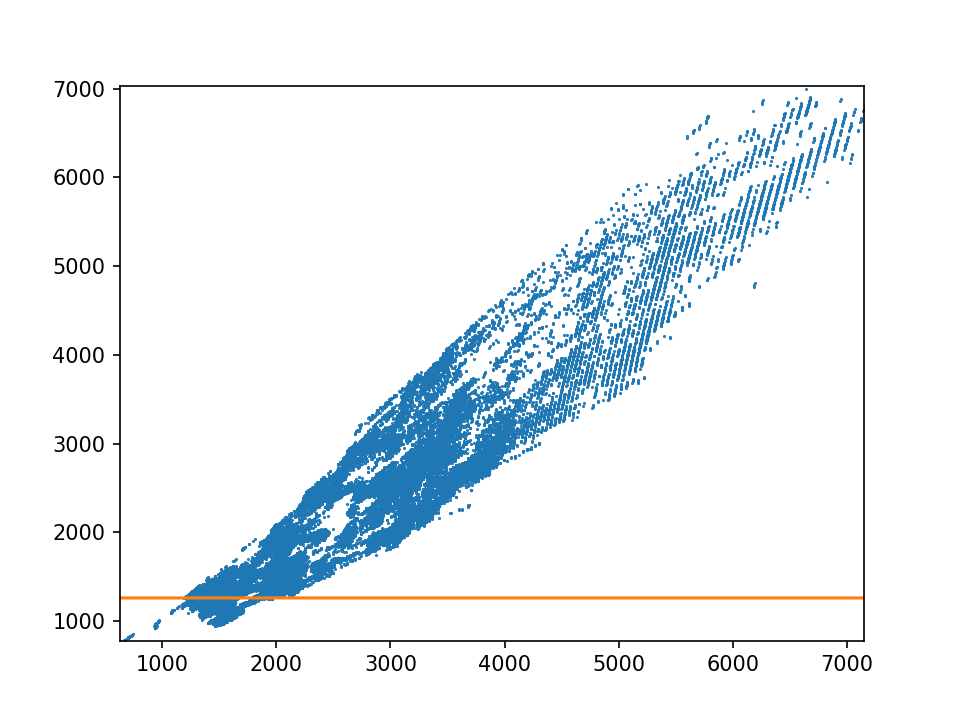

In [72]:
fig, ax = plt.subplots(1,1)
ax.plot(depth_val, heights, '.', ms=1)
x = np.arange(0,8000,1)
y = np.ones(8000)
ax.plot(x, 1260*y)

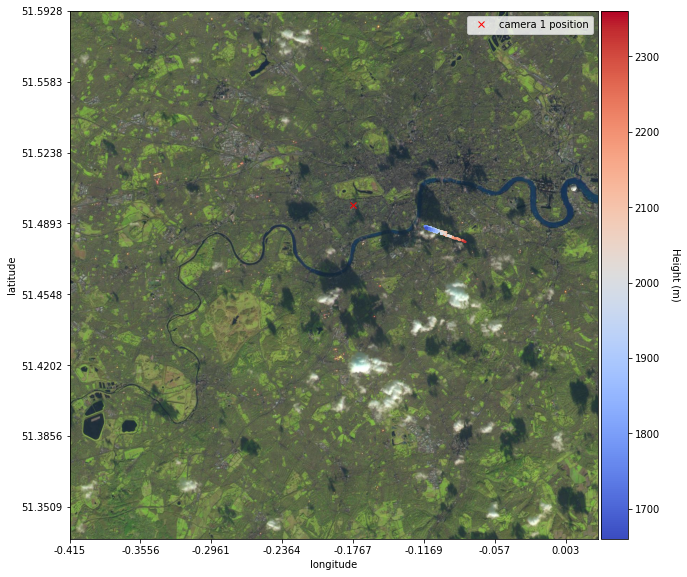

In [579]:
# from https://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file

from osgeo import gdal, osr
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
import numpy as np

ds = gdal.Open("C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2A_20210928.tif")
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()#
new_cs .ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs)

width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

def landsat_coords(i, j):
    x = gt[0] + i*gt[1] + j*gt[2]
    #y = gt[3] + (width-i)*gt[4] + (height-j)*gt[5]
    y = gt[3] + i*gt[4] + j*gt[5]
    return transform.TransformPoint(x, y)

# lat = []
# long = []
# #get the coordinates in lat long
# for i in range(int(minx),int(maxx), 20):
#     for j in range(int(miny), int(maxy), 20):
#         lat.append(transform.TransformPoint(i,j)[0])
#         long.append(transform.TransformPoint(i,j)[1])
# ##latlong = transform.TransformPoint(landsat_coords(0,0)[0], landsat_coords(0,0)[1])



px = np.arange(0,5490,1)
py = np.arange(0,5490,1)

oldx = np.array([4000,4200,4400,4600,4800,5000,5200,5400])
oldy = np.array([5400,5200,5000,4800,4600,4400,4200,4000])

gps = list(map(landsat_coords, px, py))
gps = np.array(gps)

new = list(map(landsat_coords, oldx, oldy))
new = np.array(new)
lat = new[:,0]
long = new[:,1]


im = plt.imread("C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2B_20220131.tif")
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlim(4000,5490)
ax.set_ylim(5490,4000)
ax.imshow(im)
ax.set_xticks(oldx, np.round(long, 4))
ax.set_yticks(oldy, np.round(lat, 4))
world = ax.scatter(
    coord_to_pixel_x(gps_dists_auto[:,1]), 
    coord_to_pixel_y(gps_dists_auto[:,0]), 
    2, 
    gps_dists_auto[:,2], cmap='coolwarm')
# ax.plot(-0.1788492157810761, 51.49880908055068, 'cx', label='camera 1 position')
# ax.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3 position')

c1x = coord_to_pixel_x(-0.1788492157810761)
c1y = coord_to_pixel_y(51.49880908055068)
ax.plot(c1x, c1y, 'rx', label='camera 1 position')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(world, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=20)
ax.legend()
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.savefig(f'2021-09-28_11_satellite_frame_{frame_no+1}.png', bbox_inches='tight')


In [42]:
world_coords[:,1].shape

(23751,)

In [49]:
def coord_to_pixel_x(coord, min_coord=-1.563879374885302, max_coord=0.02, points=5490):
    return (coord - min_coord) / (max_coord - min_coord) * points
def coord_to_pixel_y(coord, min_coord=51.324523354307196, max_coord=52.34135509678961, points=5490):
    return points - (coord - min_coord) / (max_coord - min_coord) * points

  Using cached cameratransform-1.2-py3-none-any.whl (48 kB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)


In [72]:
!gdalinfo "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2A_20210928.tif" 

Driver: GTiff/GeoTIFF
Files: C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2A_20210928.tif
Size is 5490, 5490
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 30N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 30N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-3,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
      

In [209]:
!pip install haversine

  Using cached haversine-2.5.1-py2.py3-none-any.whl (6.1 kB)
